# Оценка моделей

## Задача

Оценить возможности получившихся нейронных сетей (CNN, LSTM, LSTM_CNN и их ансамбли) корректно определять настроения текстов.  
Сравнить работу нейронных сетей с baseline-решениями.  
В качестве таковых решений взяты модели логистической регрессии, обученные на текстах, каждый из которых переработан в один вектор несколькими способами  
(Bag of Words, TF-IDF, Среднее арифметическое от векторов слов полученных Word2Vec, Среднее арифметическое от векторов слов полученных FastText, Doc2Vec)

## Данные

Нейронные сети и их ансамбли, сохранённые в *./models*  
Данные для обучения и текста, сохранённые в *./data*

## Расчёты

In [1]:
import torch
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score
from dataset_and_models import LABELS
from dataset_and_models import df_train, df_test
from dataset_and_models import bow_train, bow_test
from dataset_and_models import tf_idf_train, tf_idf_test
from dataset_and_models import w2v_train, w2v_test
from dataset_and_models import fasttext_train, fasttext_test
from dataset_and_models import d2v_train, d2v_test
from dataset_and_models import w2v_data_test
from dataset_and_models import fasttext_data_test
import matplotlib.pyplot as plt

In [2]:
# установка устройва для расчётов
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
def get_log_reg(data_train):
    """
    Функция обучения модели логистической регрессии
    :param data_train: данные обучения
    :return: функция логистической регрессии
    """
    return SGDClassifier(
        loss='log_loss', 
        penalty='l2'
    ).fit(
        X=data_train, 
        y=df_train['type']
    )

In [3]:
def model_result_to_tensor(model, data, device=DEVICE):
    """
    Функция переводящая результат в тензор
    :param model: модель нейронной сети или ансамбля
    :param data: тестовые данные
    :param device: устройво для основных расчётов
    :return: [реальный лейбл текста,
              лейбл текста, предсказанный моделью]
    """
    
    model.to(device)
    model.eval()

    output_model = torch.tensor([])
    output_y = torch.tensor([])

    with torch.no_grad():
        for x, y in data:
            x = x.to(device)
            output_model = torch.concat([output_model, model(x).cpu()])           
            output_y = torch.concat([output_y, y])

    # в качестве вывода модели берётся индекс максимального числа
    return [output_y, output_model.argmax(dim=1)]

In [4]:
def tensor_to_label(numbers, dict_of_labels=LABELS):
    """
    Функция перевода лейбла, в название (good, bad, neutral)
    :param numbers: тензор, для перевода 
    :param dict_of_labels: словарь, численно кодирующий название типа
    :return: список, названий типов
    """
    numbers = numbers.numpy().astype(int)
    temp_list = []

    for i in numbers:
        for j in dict_of_labels.keys():
            if dict_of_labels[j] == i:
                temp_list.append(j)
    
    return temp_list

In [6]:
def var2str(variable):
    """
    Функция получения имени переменной в виде строчки
    :param variable: переменная, с искомым именем
    :return: строчку имени данной переменной
    """
    for global_var in globals():
        if id(variable) == id(globals()[global_var]):
            return global_var

In [7]:
# загрузка всех нейронных сетей и их ансамблей
w2v_cnn = torch.load('models/w2v_cnn.pt')

fasttext_cnn = torch.load('models/fasttext_cnn.pt')

w2v_lstm = torch.load('models/w2v_lstm.pt')

fasttext_lstm = torch.load('models/fasttext_lstm.pt')

w2v_lstm_cnn = torch.load('models/w2v_lstm_cnn.pt')

fasttext_lstm_cnn = torch.load('models/fasttext_lstm_cnn.pt')

w2v_cnn_and_lstm_ensemble = torch.load('models/w2v_cnn_and_lstm_ensemble.pt')

fasttext_cnn_and_lstm_ensemble = torch.load('models/fasttext_cnn_and_lstm_ensemble.pt')

w2v_ensemble_of_lstm_cnn = torch.load('models/w2v_ensemble_of_lstm_cnn.pt')

fasttext_ensemble_of_lstm_cnn = torch.load('models/fasttext_ensemble_of_lstm_cnn.pt')

In [8]:
# обучение моделей логистической регрессии
bow_log_reg = get_log_reg(bow_train)

tf_idf_log_reg = get_log_reg(tf_idf_train)

w2v_log_reg = get_log_reg(w2v_train)

fasttext_log_reg = get_log_reg(fasttext_train)

d2v_log_reg = get_log_reg(d2v_train)

In [9]:
# порядок загрузки моделей для анализа
models_list = [
    w2v_cnn, fasttext_cnn, bow_log_reg,
    w2v_lstm, fasttext_lstm, tf_idf_log_reg,
    w2v_lstm_cnn, fasttext_lstm_cnn, w2v_log_reg,
    w2v_cnn_and_lstm_ensemble, fasttext_cnn_and_lstm_ensemble, fasttext_log_reg,
    w2v_ensemble_of_lstm_cnn, fasttext_ensemble_of_lstm_cnn, d2v_log_reg
]

In [10]:
# порядок загрузки данных для теста
test_data_list = []

test_data_for_log_res = [
    bow_test,
    tf_idf_test,
    w2v_test,
    fasttext_test,
    d2v_test
]

for i in range(5):
    test_data_list.extend(
        [
            w2v_data_test, 
            fasttext_data_test, 
            test_data_for_log_res[i]
        ]
    )

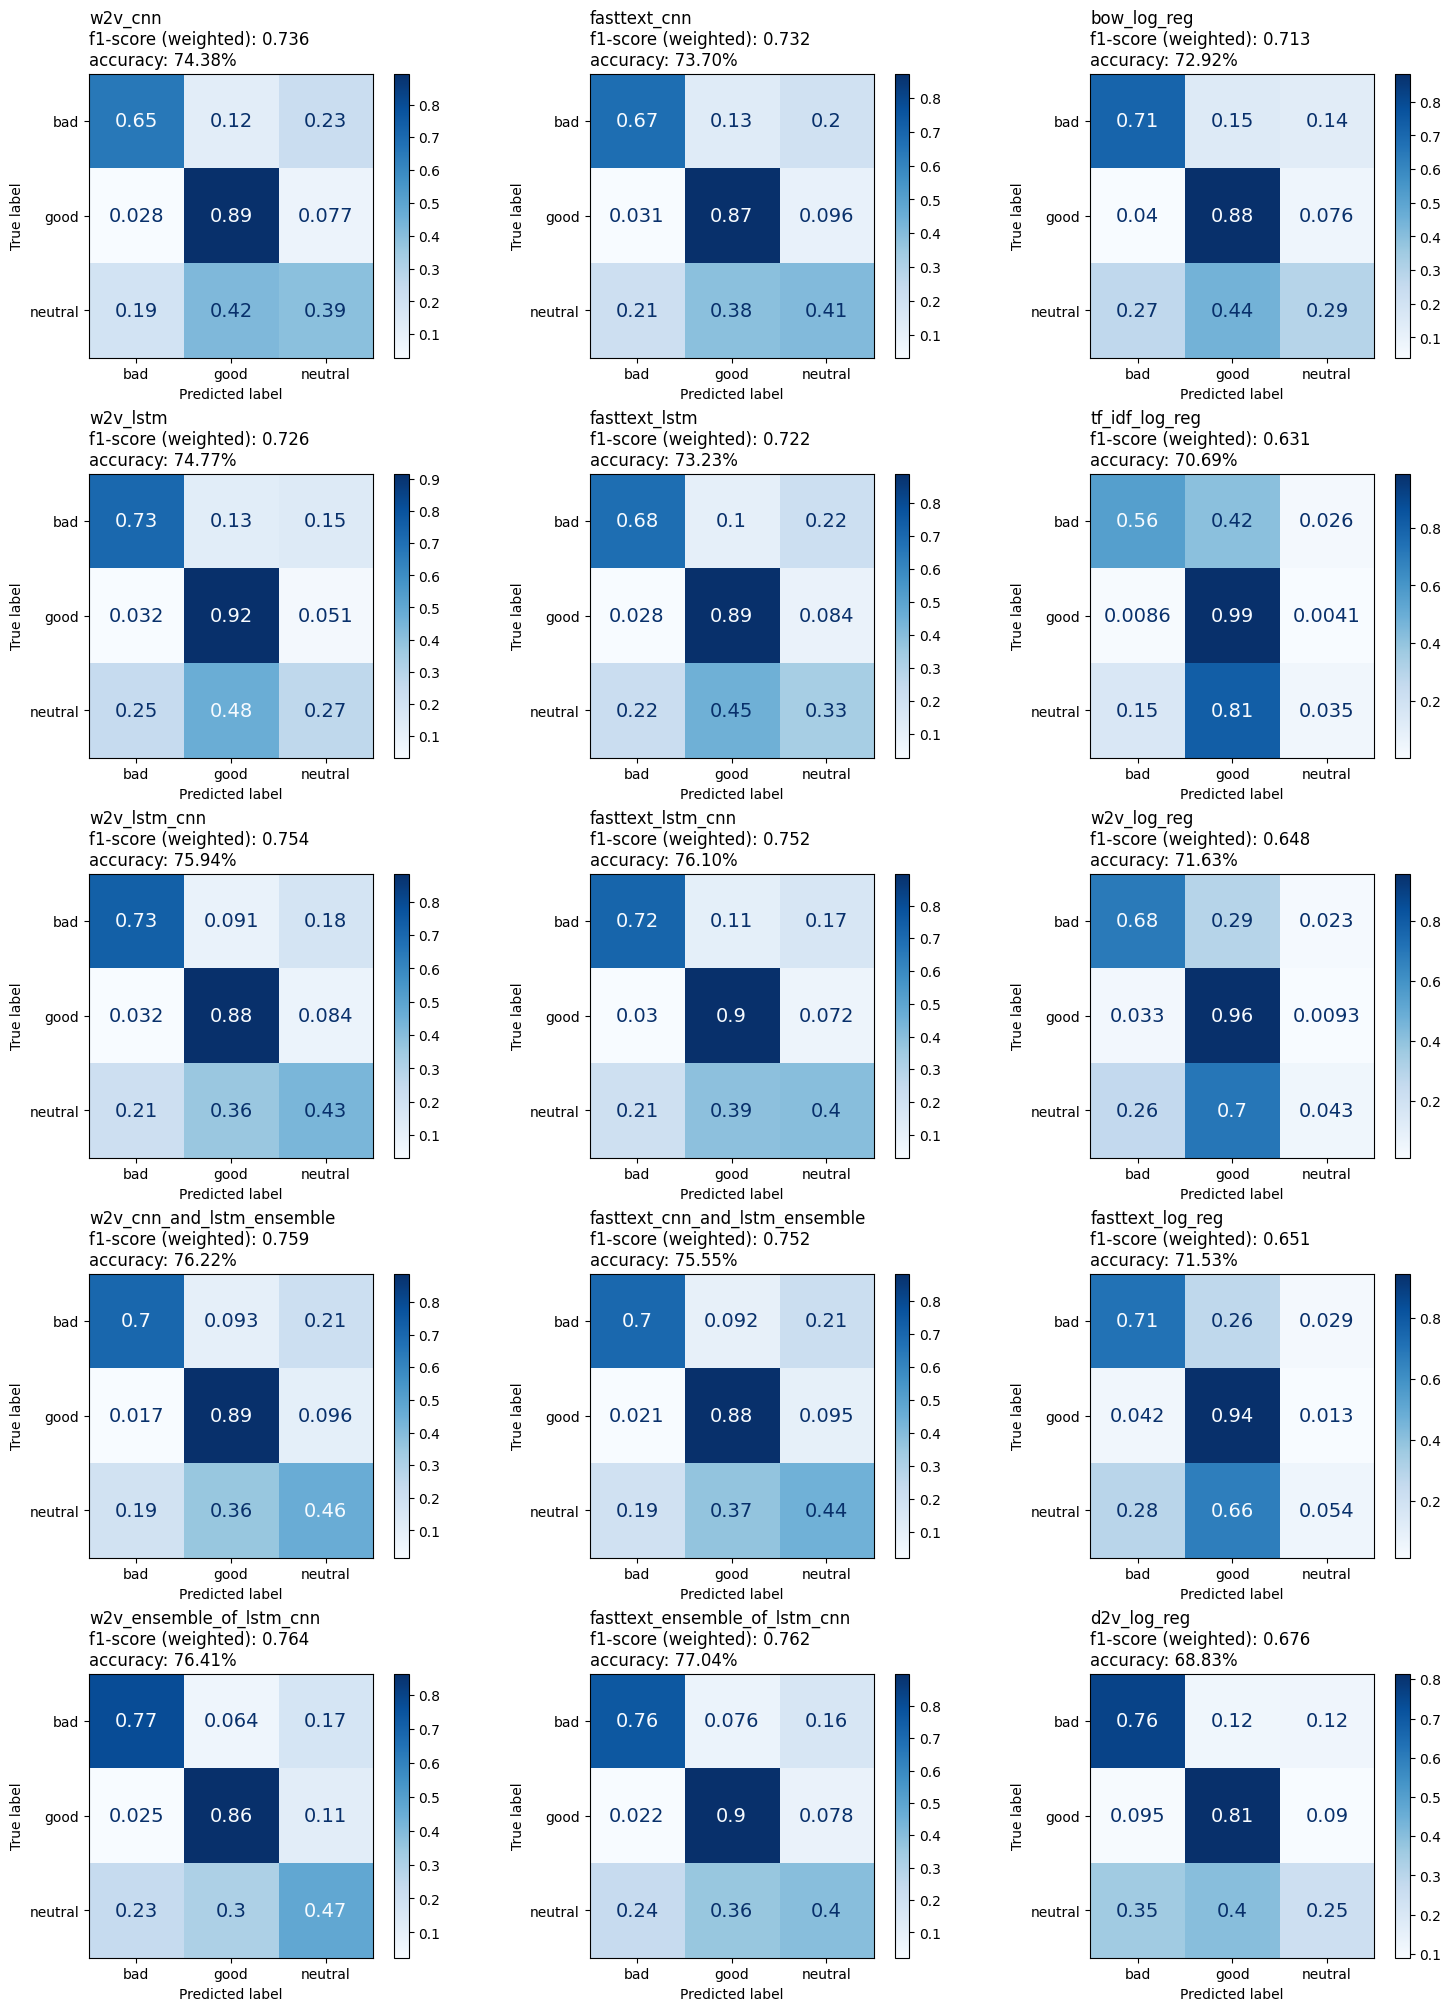

In [11]:
# вывод результатов для каждой модели
# 1ая колонка - нейронные сети и их ансамбли обучкенные на текстах обработанных Word2Vec моделью
# 2ая колонка - нейронные сети и их ансамбли обучкенные на текстах обработанных FastText моделью
# 3я колонка  - модели логистической регрессии обученных на 5 разных способах представления текста в виде вектора

fig, axs = plt.subplots(5, 3, figsize=(15, 20), layout='constrained')

label='{}\nf1-score (weighted): {:.3f}\naccuracy: {:.2f}%'

count = 1

for ax, model, test_data in zip(axs.flat, models_list, test_data_list):
    
    if count % 3 == 0:
        result = [df_test['type'], model.predict(X=test_data)]
    else:
        result = model_result_to_tensor(model, test_data)
        result = [tensor_to_label(i) for i in result]
    
    ax.set_title(
        loc='left',
        label=label.format(
            var2str(model),
            f1_score(*result, average='weighted'),
            accuracy_score(*result) * 100
        )
    )
    
    ConfusionMatrixDisplay.from_predictions(
        *result,
        cmap='Blues',
        text_kw={'fontsize': 14},
        ax=ax,
        normalize='true'
    )

    count += 1

* Всем моделям трудно отличить нейтральные тексты от положительных.
* Все получившиеся нейронные сети работают лучше любой baseline модели, независимо от способа перевода текста в вектор.
* Получившиеся CNN сети лучше справляются с задачей, нежели LSTM сети, хоть точности их выполнения схожи, но F1-score у CNN выше, а, судя по матрице ошибок, можно судить о том, что свёрточные сети лучше могут отличить нейтральный отзыв от хорошего. Но объединение этих двух архитектур под капотом одной сети оказывается успешнее, как по F1-score или по абсолютной точности классификации, так и по возможности успешного определения нейтрального отзыва.
* Ансамбль из 5ти CNN и 5ти LSTM сетей справляются с задачей примерно так же, как и одна CNN_LSTM сеть, лучше различает нейтральные отзывы, F1-score чуть лучше либо такой же.
* Ансамбль из 10ти LSTM_CNN справляется с задачей лучше всего.
* Модели, обученные на текстах, переработанных Word2Vec моделью, в основном справляются лучше, чем те, что обучены на текстах переработанных FastText моделью. 

## Результаты

* Ансамбль из 10ти LSTM_CNN сетей лучше всех может определить настроение текста, обученный на текстах, ереработанных Word2Vec моделью (наивысший F1-score).  
* Word2Vec модели желательно иметь большое количество текстов для обучения (для составления большого словаря), так как данная модель может кодировать только слова из обучающих текстов. FastText же кодирует сочетание букв, из которых уже получаются векторы слов, то есть он может кодировать слова не попавшие в обучающую выборку. А с учётом того, что FastText модели слегка уступают в точности моделям Word2Vec, то при не очень большой выборке текстов для обучения, FastText - отличный выбор.  
* Если нужна экономия памяти и вычислительных мощностей, то можно заменить ансамбль одной LSTM_CNN моделью, так как она уступает результативностью, но не сильно.